In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetBidimensionalNãoLinearmenteSeparável(n=20, n_classes=3):
    """
    Cria um dataset bidimensional multiclasse não linearmente separável.
    """
    X, y = make_blobs(n_samples=n, centers=n_classes**2, cluster_std=0.8)
    y = np.array(y%n_classes, dtype=int)
    return X, y

X, y = criaDatasetBidimensionalNãoLinearmenteSeparável(1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

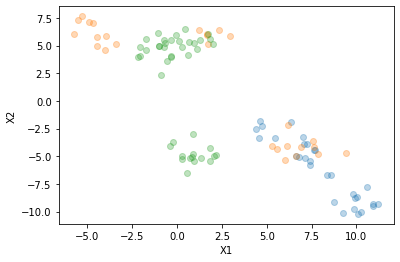

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

In [3]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [4]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [5]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [6]:
from scipy.special import expit

def tanh(a):
    return expit(a)*2-1

from abc import ABC, abstractstaticmethod

class ActivationFunction(ABC):
    @abstractstaticmethod
    def forward(a):
        pass
    @abstractstaticmethod
    def backward(a):
        pass
    @abstractstaticmethod
    def decision(a):
        pass


class Tanh(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a) * 2 - 1
    @staticmethod
    def backward(a):
        return (1 - np.square(Tanh.forward(a)))
    @staticmethod
    def decision(a):
        return (a >= 0) * 2 - 1


class Sigmoid(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a)
    @staticmethod
    def backward(a):
        return Sigmoid.forward(a) * (1 - Sigmoid.forward(a))
    @staticmethod
    def decision(a):
        return (a >= 0.5) * 2 - 1

In [7]:
def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X), axis=1)
    return Xb

class Backpropagation():
    def __init__(self, n_hidden=5, activation=Tanh()):
        self.n_hidden = n_hidden
        self.activation = activation
        self.learning_rate = 0.005
        self.max_iter = 1000
    
    def forward(self, X):
        self.Xb = includebias(X)
        self.pH = self.Xb @ self.ihw
        self.H = self.activation.forward(self.pH)
        self.Hb = includebias(self.H)
        self.prey = self.Hb @ self.how
        self.posy = self.activation.forward(self.prey)
        self.ypred = self.activation.decision(self.posy)

    def backward(self, y):
        ho_delta = y - self.ypred
        ho_grad = self.Hb.T @ ho_delta
        deriv_grad = self.activation.backward(self.pH) 
        ih_delta = (ho_delta @ self.how[1:,:].T) * deriv_grad
        ih_grad = self.Xb.T @ ih_delta
        self.how += ho_grad * self.learning_rate
        self.ihw += ih_grad * self.learning_rate
    
    def fit(self, X, y):
        self.ihw = np.random.uniform(-1, 1, size=(X.shape[1]+1, self.n_hidden))
        self.how = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1]))
        for _ in range(self.max_iter):
            self.forward(X)
            self.backward(y)
    
    def predict(self, X):
        Xb = includebias(X)
        pH = Xb @ self.ihw
        H = self.activation.forward(pH)
        Hb = includebias(H)
        prey = Hb @ self.how
        posy = self.activation.forward(prey)
        return self.activation.decision(posy)

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
    """
    Versão do MLP com daus camadas e funções de ativação parametrizadas.
    """
    def __init__(self, training_algorithm=Backpropagation()):
        self.training_algorithm = training_algorithm

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X, yhot)

    def predict(self, X):
        a = self.training_algorithm.predict(X)
        if len(self.labels) <= 2:
            idx = np.array(a > 0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

0.75
0.7555555555555555


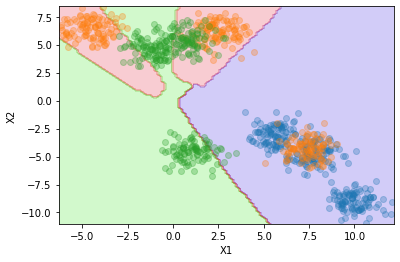

0.8
0.72


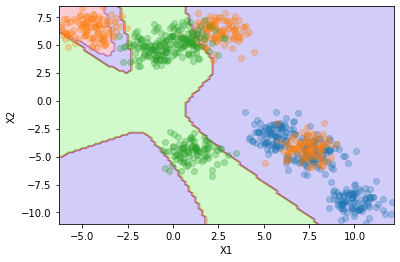

In [9]:
funções = [Tanh(), Sigmoid()]

for função in funções:
    mlp = MLP(Backpropagation(activation=função))
    mlp.fit(Xtr, ytr)
    print(accuracy(ytr, mlp.predict(Xtr)))
    print(accuracy(yte, mlp.predict(Xte)))
    plotaDatasetBidimensional(Xte, yte)
    plot_predictions(mlp, Xte)
    plt.show()